# A guide for using the Hilbert-Huang Transform in Machine Learning

## Abstract

The `Hilbert–Huang transform` (`HHT`) is a time series analysis technique specifically designed to handle nonlinear and non-stationary time series data. In contrast to other traditional spectral analysis methods, `HHT` is data-adaptive which leads to more physically meaningful components. This data driven decomposition comes at the expense of computational complexity, it is this computation factor which has seen wavelets dominate signal processing pipelines for filtering/de-noising applications. Contrast to conventional spectral analysis methods such as fourier transform and the wavelet transform, the `HHT` does not lose temporal information after transformation. This is a key advantage over alternative time series representation as input into a machine learning models. This paper attempts to showcase a comparative study of `Hilbert–Huang transform`, `Fourier transform` and `wavelet transform` as input representations into machine learning models. In performing the analyses, it is empirically demonstrated that the `Hilbert spectrum` containing estimations for **energy**, **time** and **frequency**, have a learning advantage over alternative representations when dealing with signals which contain nonlinear and/or nonstationary phenomena.   

## Contents

The contents of this Jupyter Notebook are as follows:

1. Introduction 
2. Background
    1. Fourier Transform
    2. Wavelet Transform
    3. Short-Time Fourier Transform (STFT)
3. Hilbert Spectral Analysis
    1. Hilbert Transform
    2. Empirical mode decomposition (EMD)
    3. Empirical mode Reconstruction
    4. Hilbert–Huang transform
4. Practical Machine Learning Applications
    1. UCI-HAR dataset
    2. ECG Dataset
    3. Comparative Analysis 
5. Discussion
6. Conclusions


## Introduction

The following chapter will present background knowledge on Fourier Transform, Wavelet Transform and Short-Time Fourier Transform (STFT), however the 


In this artical we will focus on implementation and theory of the `Hilbert–Huang transform`, related topics  



<div class="alert alert-block alert-warning">
<b>Warning:</b> This guide has been developed and tested using the conda environment <b>`hht`</b>, it is strongly advised to install this enviroment prior to execution of Jupyter Notebook.  
</div>

In [105]:
import numpy as np
import pandas as pd
import scipy.io as sio

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import ListedColormap
import matplotlib.pylab as pl

import h5py
from scipy.signal import hilbert, spectrogram
from PyEMD import EMD
from sklearn.preprocessing import MinMaxScaler

import pywt
from scipy import signal

from src.HHT import *
from src.biosignal_filter import denoise_biowave
from src.numpy_custom_utils import n_closest, repeating_elements

### Custom Functions

In [39]:
def color_map():
    '''Here we define a color map where 0 == white'''
    cmap = plt.cm.cividis

    # Get the colormap colors
    my_cmap = cmap(np.arange(cmap.N))

    # Set alpha
    my_cmap[:,-1] = np.linspace(0, 1, cmap.N)

    # Create new colormap
    my_cmap = ListedColormap(my_cmap)
    
    return my_cmap

def plot_wavelet(ax, time, signal, scales, waveletname = 'cmor', 
                 cmap = plt.cm.seismic, title = '', ylabel = '', xlabel = ''):
    
    dt = time[1] - time[0]
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
    power = (abs(coefficients)) ** 2
    period = 1. / frequencies
    levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
    contourlevels = np.log2(levels)
    
    im = ax.contourf(time, np.log2(period), 
                     np.log2(power), 
                     contourlevels, extend='both',cmap=cmap)
    
    ax.set_title(title)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    
def plot_HHT(ax, fs, signal, cmap = plt.cm.seismic, title = '', frequency_resolution = .2, freq_div = 2, max_freq = 25):


    T, F, spec_2d, spec_1d = Hilbert_spectrum(signal, fs, freq_div = freq_div, 
                                    n_components = 4, 
                                    frequency_resolution = frequency_resolution)

    ax.set_title(title)
    ax.pcolormesh(T, 
                  F[0:n_closest(max_freq, 1, F,mode='indexs')[0]], 
                  spec_2d[0:n_closest(max_freq, 1, F,mode='indexs')[0],:], cmap= cmap)
    ax.set_xlabel('time (sec)')
    ax.set_ylabel('Frequency (Hz)')

## Loading the UCI-HAR time-series dataset

In [36]:
def load_ecg_data(filename):
    raw_data = sio.loadmat(filename)
    list_signals = raw_data['ECGData'][0][0][0]
    list_labels = list(map(lambda x: x[0][0], raw_data['ECGData'][0][0][1]))
    return list_signals, list_labels

In [106]:
filename = './data/ECGData/ECGData.mat'
n_splits = 64


data_ecg, labels_ecg = load_ecg_data(filename)

# divide/split time segiments into smaller time segiments
labels_ecg = repeating_elements(labels_ecg, n_splits)
data_ecg = data_ecg.reshape(-1, int( data_ecg.shape[1]/n_splits) )

# training_size = int(0.6*len(labels_ecg))
# train_data_ecg = data_ecg[:training_size]
# test_data_ecg = data_ecg[training_size:]
# train_labels_ecg = labels_ecg[:training_size]
# test_labels_ecg = labels_ecg[training_size:]

In [119]:
file_path = '.\data\ECG_hht_10Hz.h5'
frequency_resolution = 0.1
n_components = 4
freq_div = 2
max_freq = 10
build = False

if build:
    f = h5py.File(file_path, 'a')

    for i, sig in enumerate(data_ecg):
        T, F, spec_2d, spec_1d = Hilbert_spectrum(sig, fs, freq_div = 2, 
                                    n_components = n_components, 
                                    frequency_resolution = frequency_resolution)

        X = spec_2d[0:n_closest(max_freq, 1, F,mode='indexs')[0],:]
        X = X.reshape(1, 100, 1024)

        if i == 0:
            f.create_dataset('X', data = X , compression="gzip", chunks=True, maxshape=(data_ecg.shape[0], 100, 1024))
        else:
            # Append new data to it
            f['X'].resize((f['X'].shape[0] + X.shape[0]), axis=0)
            f['X'][-X.shape[0]:] = X

    f.close()    

with h5py.File( file_path , 'r') as hf:
    X = hf['X'][:]

In [120]:
X.shape

(10368, 100, 1024)

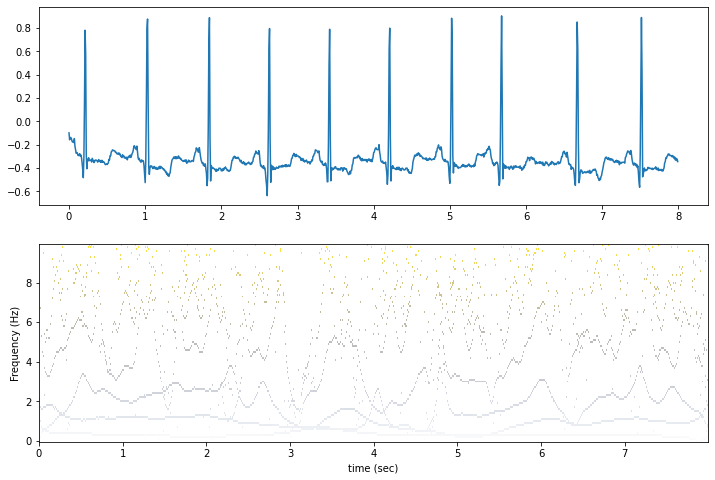

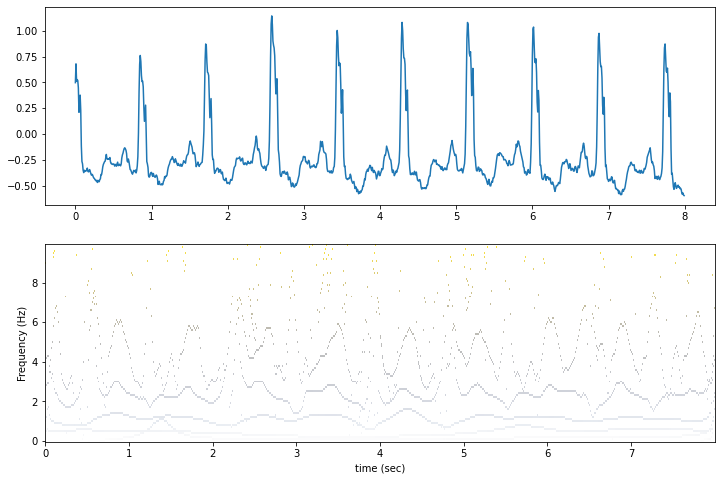

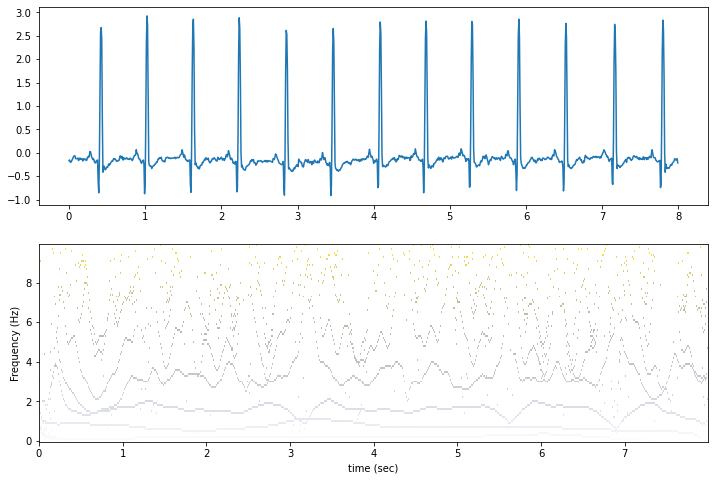

In [98]:
fs = 128
fup = 128
lenght = 1024
n = int(((lenght)/fs)*fup)



my_cmap = color_map()

for label in np.unique(labels_ecg):
    sig = data_ecg[ np.argwhere(np.array( labels_ecg ) == label)[0] ].reshape(-1)[0:lenght]
    sig = signal.resample(sig, n )
    
    fig, axes = plt.subplots(2, 1, figsize=(12,8))
    n_samples  = sig.shape[0]-1
    T = np.linspace(0, (1/fup)*n_samples, num=int((1/fup)*n_samples/(1/fup))+1)
    axes[0].plot(T,sig)
    plot_HHT(axes[1], fup, sig, cmap = my_cmap, title = '', 
             frequency_resolution = .1, freq_div = 2, max_freq = 10)
    
    plt.show()

In [80]:
# 65536 / 64

In [48]:
fs = 128
sig = train_data_ecg[0][0:1000]


In [56]:
fs = 128


In [55]:
128 *2

256

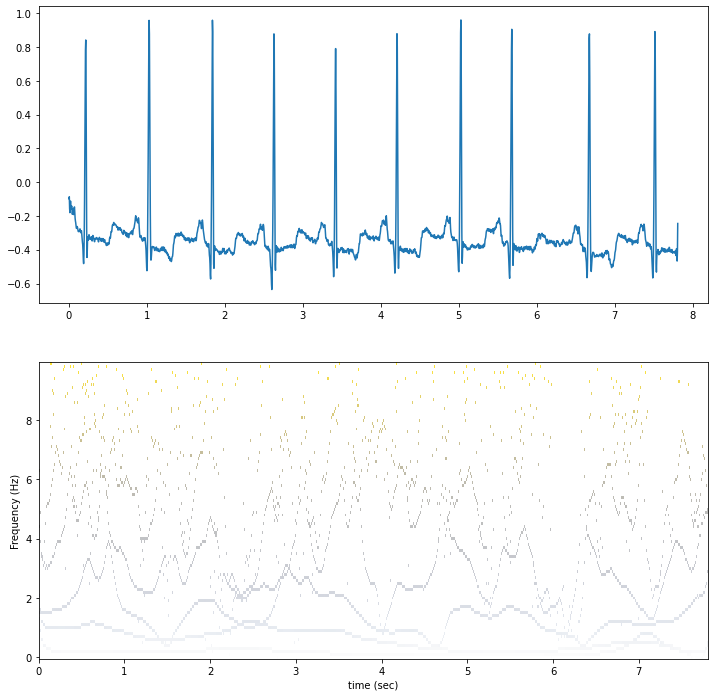

In [5]:
from sklearn.model_selection import StratifiedKFold

from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dense, Dropout, Flatten, Conv1DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from keras.callbacks import History 
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from keras.utils import to_categorical

from keras.callbacks import EarlyStopping, ModelCheckpoint
from src.keras_custom_utils import CustomStopper, plot_history

from keras.callbacks import History 
history = History()

In [6]:
# set environment variables 
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
# allow all GPU memory to be consumed by Tensorflow
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [10]:
# test hardware configuration to ensure GPUs are operational 
print( tf.test.is_built_with_cuda() )
print( tf.config.list_physical_devices() )

True
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [11]:
class cwt_cnn(object):
    def __init__(self, img_x = 127, img_y= 127, n_inputs = 9, 
                 num_classes = 6, model_name = "CWT", learning_rate = 0.001 ):
        
        # define model for neural network 
        cwt_input = Input(shape=(img_x, img_y, n_inputs), name='cwt_image')
        x = Conv2D(filters=32, kernel_size=(5, 5), padding="same", strides = (1, 1), activation="relu", name='e')(cwt_input)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
        
        x = Conv2D(filters=64, kernel_size=(5, 5), padding="same", strides=(2, 2), activation="relu",name='l')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        
        x = Flatten()(x)
        x = Dense(100, activation='relu')(x)
        x = Dropout(rate=0.2)(x)
        cwt_out = Dense(num_classes, activation='softmax')(x)
        
        model = Model(cwt_input, cwt_out, name=model_name)
        
        opt = Adam(learning_rate=learning_rate)
        model.compile(loss=categorical_crossentropy,
              optimizer=opt,
              metrics=['accuracy'])
        self.model = model
        
    def summery(self):
        return self.model.summary()
    
    def view_model(self):
        return plot_model(self.model)

In [24]:
def basic_cnn(img_x = 127, img_y= 127, n_inputs = 9, um_classes = 6, model_name = "CWT", learning_rate = 0.001 ):
    # define model for neural network 
        cwt_input = Input(shape=(img_x, img_y, n_inputs), name='cwt_image')
        x = Conv2D(filters=32, kernel_size=(5, 5), padding="same", strides = (1, 1), activation="relu", name='e')(cwt_input)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
        
        x = Conv2D(filters=64, kernel_size=(5, 5), padding="same", strides=(2, 2), activation="relu",name='l')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        
        x = Flatten()(x)
        x = Dense(100, activation='relu')(x)
        x = Dropout(rate=0.2)(x)
        cwt_out = Dense(num_classes, activation='softmax')(x)
        
        model = Model(cwt_input, cwt_out, name=model_name)
        return model

In [12]:
cwt = cwt_cnn(img_x = 1280, img_y= 50)
print(cwt.summery())

Model: "CWT"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cwt_image (InputLayer)       [(None, 1280, 50, 9)]     0         
_________________________________________________________________
e (Conv2D)                   (None, 1280, 50, 32)      7232      
_________________________________________________________________
batch_normalization_2 (Batch (None, 1280, 50, 32)      128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 640, 25, 32)       0         
_________________________________________________________________
l (Conv2D)                   (None, 320, 13, 64)       51264     
_________________________________________________________________
batch_normalization_3 (Batch (None, 320, 13, 64)       256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 160, 6, 64)        0       

True
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [16]:
build_wav = False
save = False

scales = range(1,128)
waveletname = 'morl'

if build_wav:
    
    X = np.ndarray(shape=(X_trainVal.shape[0], 127, 127, 9))
    for i in range(X_trainVal.shape[0]):
        for j in range(X_trainVal.T.shape[0]):
            coeff, freq = pywt.cwt(X_trainVal[i, :, j], scales, waveletname, 1)
            X[i, :, :, j] = coeff[:,:127]
    # The values of the label are out of range as it starts at 1 and not 0
    y_trainVal_cat = to_categorical(y_trainVal-1)

    if save:
        np.save('./data/X_morl_wav.npy', X)
        np.save('./data/Y_cat.npy', y_trainVal_cat)
else:
    X = np.load( './data/X_morl_wav.npy' )
    y_trainVal_cat = np.load( './data/Y_cat.npy' )

In [17]:
num_classes = 6
batch_size = 256
epochs = 10

skf = StratifiedKFold( n_splits = 10, shuffle=False )
skf.get_n_splits(X_trainVal, y_trainVal)

for train_index, test_index in skf.split(X_trainVal, y_trainVal):

    X_train, X_Val = X[train_index], X[test_index]
    y_train, y_Val = y_trainVal_cat[train_index], y_trainVal_cat[test_index]
    
    history = History()
    
    # define GPU strategy
    mirrored_strategy = tf.distribute.MirroredStrategy(
        cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

    with mirrored_strategy.scope():
        # aquire model with random weights
        model = cwt_cnn()
        model.model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(X_Val, y_Val), 
              callbacks=[history])
    
    break


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensor

In [18]:
train_score = model.model.evaluate(X_train, y_train, verbose=0)
print('Train loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
test_score = model.model.evaluate(X_Val, y_Val, verbose=0)
print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))

Train loss: 0.18004874885082245, Train accuracy: 0.9407497048377991
Test loss: 0.3640809953212738, Test accuracy: 0.904891312122345


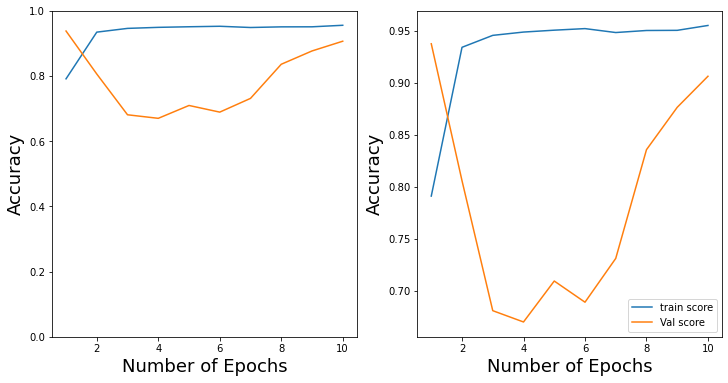

In [19]:
fig, axarr = plt.subplots(figsize=(12,6), ncols=2)
axarr[0].plot(range(1, 11), history.history['accuracy'], label='train score')
axarr[0].plot(range(1, 11), history.history['val_accuracy'], label='Val score')
axarr[0].set_xlabel('Number of Epochs', fontsize=18)
axarr[0].set_ylabel('Accuracy', fontsize=18)
axarr[0].set_ylim([0,1])
axarr[1].plot(range(1, 11), history.history['accuracy'], label='train score')
axarr[1].plot(range(1, 11), history.history['val_accuracy'], label='Val score')
axarr[1].set_xlabel('Number of Epochs', fontsize=18)
axarr[1].set_ylabel('Accuracy', fontsize=18)
#axarr[1].set_ylim([0.9,1])
plt.legend()
plt.show()

In [20]:
y_test_cat = to_categorical(y_test-1) 
X_test_wav = np.ndarray(shape=(X_test.shape[0], 127, 127, 9))
for i in range(X_test.shape[0]):
    for j in range(X_test.T.shape[0]):
        coeff, freq = pywt.cwt(X_test[i, :, j], scales, waveletname, 1)
        X_test_wav[i, :, :, j] = coeff[:,:127]

In [21]:
test_score = model.model.evaluate(X_test_wav, y_test_cat, verbose=0)
print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))

Test loss: 0.539482831954956, Test accuracy: 0.8693586587905884


In [10]:
build_wav = True
save = True

frequency_resolution = 0.1
n_components = 4
freq_div = 2

f = h5py.File('.\data\X_hht_10Hz.h5', 'a')
# 
X = np.ndarray(shape=(1, 50, n, 9))
for i in range(X_trainVal.shape[0]):

    for j in range(X_trainVal.T.shape[0]):

        T, F, spec_2d, spec_1d = Hilbert_spectrum(signal.resample(X_trainVal[i, :, j], n ), 500, freq_div = 2, 
                                n_components = n_components, 
                                frequency_resolution = frequency_resolution)
        
        X[0, :, :, j] = spec_2d[0:n_closest(5, 1, F,mode='indexs')[0],:]
    
    if i == 0:
        f.create_dataset('X', data=X, compression="gzip", chunks=True, maxshape=(X_trainVal.shape[0], 50, n, 9))
    else:
        # Append new data to it
        f['X'].resize((f['X'].shape[0] + X.shape[0]), axis=0)
        f['X'][-X.shape[0]:] = X
f.close()

NameError: name 'n' is not defined

In [11]:
X.shape

NameError: name 'X' is not defined

In [4]:
with h5py.File('.\data\X_hht_10Hz.h5', 'r') as hf:
    X_trainVal = hf['X'][:]
    
np.save('.\data\X_hht_10Hz_1.npy', X_trainVal[0:int((X_trainVal.shape[0]/2)),:,:])
np.save('.\data\X_hht_10Hz_2.npy', X_trainVal[int((X_trainVal.shape[0]/2)):,:,:])

In [13]:
X_trainVal = np.load('.\data\X_hht_10Hz_1.npy')
y_trainVal_cat = np.load( './data/Y_cat.npy' )
y_trainVal_cat = y_trainVal_cat[0:X_trainVal.shape[0]]
y_trainVal = y_trainVal[0:X_trainVal.shape[0]]

In [14]:
X_trainVal.shape, y_trainVal_cat.shape

((3676, 50, 1280, 9), (3676, 6))

In [25]:
num_classes = 6
batch_size = 256
epochs = 1000

skf = StratifiedKFold( n_splits = 10, shuffle=False )
skf.get_n_splits(X_trainVal, y_trainVal)

for train_index, test_index in skf.split(X_trainVal, y_trainVal):

    history = History()
    
    # define GPU strategy
    mirrored_strategy = tf.distribute.MirroredStrategy(
        cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

    with mirrored_strategy.scope():
        # aquire model with random weights
        model = basic_cnn(img_x = 50, img_y= 1280,learning_rate = 0.002)
        

        model.compile( loss = categorical_crossentropy, optimizer = 'SGD', metrics = ["accuracy"] ) 
        
        model.fit(X_trainVal[train_index], y_trainVal_cat[train_index],
                        batch_size=batch_size,
                        epochs=epochs,
                        shuffle = True,
                        verbose=1,
                        validation_data=(X_trainVal[test_index], y_trainVal_cat[test_index]), 
                        callbacks=[history])
    
    break

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Epoch 1/1000
13/13 [==============================] - 14s 535ms/step - loss: 0.0907 - accuracy: 0.1892 - val_loss: 0.0694 - val_accuracy: 0.2011
Epoch 2/1000
13/13 [==============================] - 4s 318ms/step - loss: 0.0809 - accuracy: 0.1831 - val_loss: 0.0693 - val_accuracy: 0.2065
Epoch 3/1000
13/13 [==============================] - 4s 311ms/step - loss: 0.0740 - accuracy: 0.2196 - val_loss: 0.0691 - val_accuracy: 0.1929
Epoch 4/1000
13/13 [==============================] - 4s 319ms/step - loss: 0.0709 - accuracy: 0.2518 - val_loss: 0.0690 - val_accuracy: 0.2092
Epoch 5/1000
13/13 [==============================] - 4s 295ms/step - loss: 0.0686 - accuracy: 0.2718 - val_loss: 0.0688 - val_accuracy: 0.2201
Epoch 6/1000
13/13 [==============================] - 4s 310ms/step - loss: 0.0674 - accuracy: 0.2750 - val_loss: 0.0687 - val_acc

13/13 [==============================] - 4s 309ms/step - loss: 0.0060 - accuracy: 0.9816 - val_loss: 0.0599 - val_accuracy: 0.4457
Epoch 113/1000
13/13 [==============================] - 4s 306ms/step - loss: 0.0056 - accuracy: 0.9829 - val_loss: 0.0598 - val_accuracy: 0.4484
Epoch 114/1000
13/13 [==============================] - 4s 315ms/step - loss: 0.0059 - accuracy: 0.9804 - val_loss: 0.0597 - val_accuracy: 0.4375
Epoch 115/1000
13/13 [==============================] - 4s 304ms/step - loss: 0.0056 - accuracy: 0.9797 - val_loss: 0.0599 - val_accuracy: 0.4484
Epoch 116/1000
13/13 [==============================] - 4s 313ms/step - loss: 0.0051 - accuracy: 0.9867 - val_loss: 0.0598 - val_accuracy: 0.4457
Epoch 117/1000
13/13 [==============================] - 4s 309ms/step - loss: 0.0054 - accuracy: 0.9882 - val_loss: 0.0598 - val_accuracy: 0.4484
Epoch 118/1000
13/13 [==============================] - 4s 305ms/step - loss: 0.0050 - accuracy: 0.9848 - val_loss: 0.0599 - val_accuracy: 

13/13 [==============================] - 4s 313ms/step - loss: 0.0016 - accuracy: 0.9988 - val_loss: 0.0596 - val_accuracy: 0.4701
Epoch 225/1000
13/13 [==============================] - 4s 306ms/step - loss: 0.0017 - accuracy: 0.9985 - val_loss: 0.0594 - val_accuracy: 0.4701
Epoch 226/1000
13/13 [==============================] - 4s 295ms/step - loss: 0.0017 - accuracy: 0.9976 - val_loss: 0.0596 - val_accuracy: 0.4620
Epoch 227/1000
13/13 [==============================] - 4s 302ms/step - loss: 0.0015 - accuracy: 0.9978 - val_loss: 0.0595 - val_accuracy: 0.4701
Epoch 228/1000
13/13 [==============================] - 4s 311ms/step - loss: 0.0016 - accuracy: 0.9993 - val_loss: 0.0595 - val_accuracy: 0.4701
Epoch 229/1000
13/13 [==============================] - 4s 307ms/step - loss: 0.0015 - accuracy: 0.9991 - val_loss: 0.0599 - val_accuracy: 0.4647
Epoch 230/1000
13/13 [==============================] - 4s 315ms/step - loss: 0.0019 - accuracy: 0.9969 - val_loss: 0.0597 - val_accuracy: 

Epoch 336/1000
13/13 [==============================] - 4s 301ms/step - loss: 0.0010 - accuracy: 0.9991 - val_loss: 0.0598 - val_accuracy: 0.4755
Epoch 337/1000
13/13 [==============================] - 4s 311ms/step - loss: 9.7846e-04 - accuracy: 0.9992 - val_loss: 0.0599 - val_accuracy: 0.4783
Epoch 338/1000
13/13 [==============================] - 4s 308ms/step - loss: 9.7513e-04 - accuracy: 0.9990 - val_loss: 0.0598 - val_accuracy: 0.4728
Epoch 339/1000
13/13 [==============================] - 4s 312ms/step - loss: 9.5813e-04 - accuracy: 0.9981 - val_loss: 0.0598 - val_accuracy: 0.4701
Epoch 340/1000
13/13 [==============================] - 4s 312ms/step - loss: 0.0010 - accuracy: 0.9985 - val_loss: 0.0597 - val_accuracy: 0.4728
Epoch 341/1000
13/13 [==============================] - 4s 316ms/step - loss: 9.8747e-04 - accuracy: 0.9992 - val_loss: 0.0597 - val_accuracy: 0.4755
Epoch 342/1000
13/13 [==============================] - 4s 320ms/step - loss: 7.9186e-04 - accuracy: 0.9992 

Epoch 391/1000
13/13 [==============================] - 4s 298ms/step - loss: 7.3947e-04 - accuracy: 0.9992 - val_loss: 0.0598 - val_accuracy: 0.4755
Epoch 392/1000
13/13 [==============================] - 4s 301ms/step - loss: 7.4938e-04 - accuracy: 0.9991 - val_loss: 0.0597 - val_accuracy: 0.4783
Epoch 393/1000
13/13 [==============================] - 4s 301ms/step - loss: 7.5917e-04 - accuracy: 0.9995 - val_loss: 0.0597 - val_accuracy: 0.4783
Epoch 394/1000
13/13 [==============================] - 4s 302ms/step - loss: 7.9253e-04 - accuracy: 0.9986 - val_loss: 0.0598 - val_accuracy: 0.4783
Epoch 395/1000
13/13 [==============================] - 4s 308ms/step - loss: 7.8452e-04 - accuracy: 0.9995 - val_loss: 0.0597 - val_accuracy: 0.4755
Epoch 396/1000
13/13 [==============================] - 4s 314ms/step - loss: 8.8715e-04 - accuracy: 0.9989 - val_loss: 0.0599 - val_accuracy: 0.4783
Epoch 397/1000
13/13 [==============================] - 4s 313ms/step - loss: 6.5925e-04 - accuracy:

Epoch 500/1000
13/13 [==============================] - 4s 304ms/step - loss: 6.5144e-04 - accuracy: 0.9989 - val_loss: 0.0600 - val_accuracy: 0.4810
Epoch 501/1000
13/13 [==============================] - 4s 305ms/step - loss: 5.4313e-04 - accuracy: 0.9991 - val_loss: 0.0599 - val_accuracy: 0.4755
Epoch 502/1000
13/13 [==============================] - 4s 305ms/step - loss: 5.7810e-04 - accuracy: 0.9990 - val_loss: 0.0600 - val_accuracy: 0.4674
Epoch 503/1000
13/13 [==============================] - 4s 312ms/step - loss: 7.0049e-04 - accuracy: 0.9990 - val_loss: 0.0598 - val_accuracy: 0.4755
Epoch 504/1000
13/13 [==============================] - 4s 319ms/step - loss: 5.1995e-04 - accuracy: 0.9997 - val_loss: 0.0599 - val_accuracy: 0.4728
Epoch 505/1000
13/13 [==============================] - 4s 295ms/step - loss: 6.2275e-04 - accuracy: 1.0000 - val_loss: 0.0599 - val_accuracy: 0.4674
Epoch 506/1000
13/13 [==============================] - 4s 294ms/step - loss: 6.6259e-04 - accuracy:

Epoch 609/1000
13/13 [==============================] - 4s 311ms/step - loss: 4.6697e-04 - accuracy: 0.9998 - val_loss: 0.0600 - val_accuracy: 0.4783
Epoch 610/1000
13/13 [==============================] - 4s 304ms/step - loss: 4.7362e-04 - accuracy: 0.9997 - val_loss: 0.0600 - val_accuracy: 0.4728
Epoch 611/1000
13/13 [==============================] - 4s 313ms/step - loss: 4.9579e-04 - accuracy: 1.0000 - val_loss: 0.0600 - val_accuracy: 0.4755
Epoch 612/1000
13/13 [==============================] - 4s 318ms/step - loss: 5.2654e-04 - accuracy: 0.9985 - val_loss: 0.0601 - val_accuracy: 0.4701
Epoch 613/1000
13/13 [==============================] - 4s 317ms/step - loss: 3.8701e-04 - accuracy: 0.9998 - val_loss: 0.0601 - val_accuracy: 0.4755
Epoch 614/1000
13/13 [==============================] - 4s 305ms/step - loss: 3.7671e-04 - accuracy: 0.9997 - val_loss: 0.0602 - val_accuracy: 0.4728
Epoch 615/1000
13/13 [==============================] - 4s 319ms/step - loss: 3.6953e-04 - accuracy:

Epoch 718/1000
13/13 [==============================] - 4s 313ms/step - loss: 3.8722e-04 - accuracy: 0.9994 - val_loss: 0.0604 - val_accuracy: 0.4783
Epoch 719/1000
13/13 [==============================] - 4s 311ms/step - loss: 3.0501e-04 - accuracy: 1.0000 - val_loss: 0.0603 - val_accuracy: 0.4728
Epoch 720/1000
13/13 [==============================] - 4s 305ms/step - loss: 3.2716e-04 - accuracy: 0.9998 - val_loss: 0.0604 - val_accuracy: 0.4810
Epoch 721/1000
13/13 [==============================] - 4s 311ms/step - loss: 4.8533e-04 - accuracy: 0.9979 - val_loss: 0.0603 - val_accuracy: 0.4810
Epoch 722/1000
13/13 [==============================] - 4s 321ms/step - loss: 3.6302e-04 - accuracy: 0.9995 - val_loss: 0.0604 - val_accuracy: 0.4783
Epoch 723/1000
13/13 [==============================] - 4s 308ms/step - loss: 3.5670e-04 - accuracy: 0.9998 - val_loss: 0.0603 - val_accuracy: 0.4783
Epoch 724/1000
13/13 [==============================] - 4s 313ms/step - loss: 3.7730e-04 - accuracy:

Epoch 827/1000
13/13 [==============================] - 4s 315ms/step - loss: 3.0955e-04 - accuracy: 0.9995 - val_loss: 0.0603 - val_accuracy: 0.4864
Epoch 828/1000
13/13 [==============================] - 4s 306ms/step - loss: 3.6030e-04 - accuracy: 1.0000 - val_loss: 0.0603 - val_accuracy: 0.4864
Epoch 829/1000
13/13 [==============================] - 4s 310ms/step - loss: 2.3322e-04 - accuracy: 0.9997 - val_loss: 0.0604 - val_accuracy: 0.4864
Epoch 830/1000
13/13 [==============================] - 4s 308ms/step - loss: 2.7119e-04 - accuracy: 0.9997 - val_loss: 0.0604 - val_accuracy: 0.4864
Epoch 831/1000
13/13 [==============================] - 4s 305ms/step - loss: 2.9717e-04 - accuracy: 0.9998 - val_loss: 0.0604 - val_accuracy: 0.4810
Epoch 832/1000
13/13 [==============================] - 4s 308ms/step - loss: 3.3331e-04 - accuracy: 0.9991 - val_loss: 0.0605 - val_accuracy: 0.4810
Epoch 833/1000
13/13 [==============================] - 4s 314ms/step - loss: 2.8405e-04 - accuracy:

Epoch 936/1000
13/13 [==============================] - 4s 297ms/step - loss: 2.0133e-04 - accuracy: 0.9998 - val_loss: 0.0606 - val_accuracy: 0.4891
Epoch 937/1000
13/13 [==============================] - 4s 314ms/step - loss: 2.7764e-04 - accuracy: 1.0000 - val_loss: 0.0606 - val_accuracy: 0.4837
Epoch 938/1000
13/13 [==============================] - 4s 305ms/step - loss: 1.9683e-04 - accuracy: 1.0000 - val_loss: 0.0605 - val_accuracy: 0.4837
Epoch 939/1000
13/13 [==============================] - 4s 316ms/step - loss: 3.6671e-04 - accuracy: 0.9994 - val_loss: 0.0605 - val_accuracy: 0.4837
Epoch 940/1000
13/13 [==============================] - 4s 310ms/step - loss: 2.8681e-04 - accuracy: 0.9996 - val_loss: 0.0607 - val_accuracy: 0.4891
Epoch 941/1000
13/13 [==============================] - 4s 304ms/step - loss: 3.0945e-04 - accuracy: 0.9987 - val_loss: 0.0606 - val_accuracy: 0.4864
Epoch 942/1000
13/13 [==============================] - 4s 305ms/step - loss: 2.7334e-04 - accuracy:

In [27]:
train_score = model.evaluate(X_trainVal[train_index], y_trainVal_cat[train_index], verbose=0)
print('Train loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
test_score = model.evaluate(X_trainVal[test_index], y_trainVal_cat[test_index], verbose=0)
print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))

Train loss: 1.1751935744541697e-05, Train accuracy: 1.0
Test loss: 0.0605517253279686, Test accuracy: 0.48641303181648254


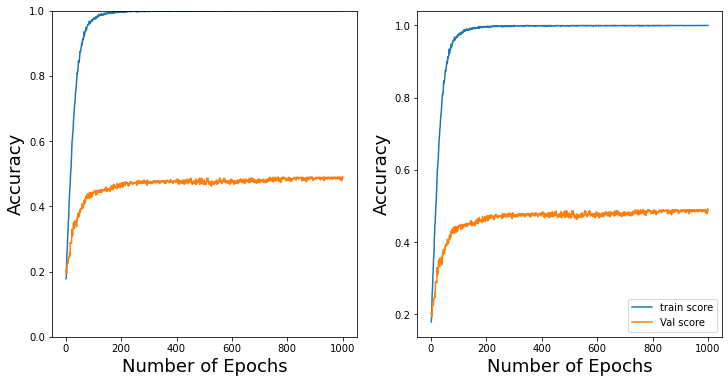

In [28]:
fig, axarr = plt.subplots(figsize=(12,6), ncols=2)
axarr[0].plot(range(1, 1001), history.history['accuracy'], label='train score')
axarr[0].plot(range(1, 1001), history.history['val_accuracy'], label='Val score')
axarr[0].set_xlabel('Number of Epochs', fontsize=18)
axarr[0].set_ylabel('Accuracy', fontsize=18)
axarr[0].set_ylim([0,1])
axarr[1].plot(range(1, 1001), history.history['accuracy'], label='train score')
axarr[1].plot(range(1, 1001), history.history['val_accuracy'], label='Val score')
axarr[1].set_xlabel('Number of Epochs', fontsize=18)
axarr[1].set_ylabel('Accuracy', fontsize=18)
#axarr[1].set_ylim([0.9,1])
plt.legend()
plt.show()

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.hilbert.html
https://uk.mathworks.com/help/signal/ug/hilbert-transform.html
https://towardsdatascience.com/instantaneous-phase-and-magnitude-with-the-hilbert-transform-40a73985be07
https://www.sciencedirect.com/topics/engineering/hilbert-transform
https://www.comm.utoronto.ca/frank/notes/hilbert.pdf


https://www.gaussianwaves.com/2017/04/analytic-signal-hilbert-transform-and-fft/
https://www.comm.utoronto.ca/frank/notes/hilbert.pdf

https://www.gaussianwaves.com/2015/11/interpreting-fft-results-complex-dft-frequency-bins-and-fftshift/

file:///C:/Users/ebolger2/Downloads/energies-10-00188-v2.pdf

https://www.researchgate.net/post/What_is_the_difference_between_wavelet_transform_and_Hilbert-Huang_transform#:~:text=Wavelet%20transform%20convolves%20a%20signal,basis%20function%20or%20mother%20wavelet.

https://www.kaggle.com/code/asauve/a-gentle-introduction-to-wavelet-for-data-analysis/notebook

https://dsp.stackexchange.com/questions/69614/inverse-hilbert-transform

https://pyhht.readthedocs.io/en/latest/tutorials/hilbert_view_nonlinearity.html

https://www.tandfonline.com/doi/abs/10.1080/00423110802167466

https://fairyonice.github.io/implement-the-spectrogram-from-scratch-in-python.html

https://ataspinar.com/2018/04/04/machine-learning-with-signal-processing-techniques/
https://archive.ics.uci.edu/ml/index.php
https://ataspinar.com/2018/04/04/machine-learning-with-signal-processing-techniques/

https://github.com/taspinar/siml/tree/master/notebooks
https://github.com/taspinar/siml/blob/master/notebooks/WV2%20-%20Visualizing%20the%20Scaleogram%2C%20time-axis%20and%20Fourier%20Transform.ipynb
https://github.com/taspinar/siml/blob/master/notebooks/WV3%20-%20Classification%20of%20signals%20using%20the%20CWT%20and%20CNN.ipynb
https://notebook.community/Mashimo/datascience/00-tidyData/CleanDataHAR

In [77]:
np.random.shuffle(train_index)
#train_index

In [78]:
y_trainVal[train_index][0:10]

array([4, 4, 5, 1, 1, 2, 6, 4, 6, 1])

# References

**Fast Fourier Transform**
* Cooley, James W., and John W. Tukey, 1965, “An algorithm for the machine calculation of complex Fourier series,” Math. Comput. 19: 297-301.

* Bluestein, L., 1970, “A linear filtering approach to the computation of discrete Fourier transform”. IEEE Transactions on Audio and Electroacoustics. 18 (4): 451-455.

* D. Gabor, “Theory of communications”, Journal of the Inst. Electr. Eng., vol. 93, pt. 111, pp. 42-57, 1946. See definition of complex signal on p. 432.

* J. A. Ville, “Theorie et application de la notion du signal analytique”, Cables el Transmission, vol. 2, [pp. 61-74, 1948](https://ieeexplore.ieee.org/document/1163127).


The Fourier transform generalizes Fourier coefficients of a signal over time. Since the Fourier coefficients are the measures of the signal amplitude as a function of frequency, the time information is totally lost. 

A powerful variant of the Fourier transform is the wavelet transform. By using finite-support basis functions, wavelets are able to approximate even nonstationary data. These basis functions possess most of the desirable properties required for linear decomposition (like orthogonality, completeness , etc) and they can be drawn from a large dictionary of wavelets. This makes the wavelet transform a versatile tool for analysis of nonstationary data. But the wavelet transform is still a linear decomposition and hence suffers from related problems like the uncertainty principle. Moreover, like Fourier, the wavelet transform too is non-adaptive. The basis functions are selected a priori and consequently make the wavelet decomposition prone to spurious harmonics and ultimately incorrect interpretations of the data.

A remarkable advantage of Fourier based methods is their mathematical framework. Fourier based methods are so elegant that they make building models for a given dataset very easy. Although such models can represent most of the data and are extensive enough for a practical application, the fact remains that there is some amount of data slipping through the gaps left behind by linear approximations. Despite all these shortcomings, wavelet analysis still remains the best possible method for analysis of nonstationary data, and hence should be used as a reference to establish the validity of other methods.

The Hilbert-Huang transform is an algorithm developed empirically to overcome these short commings, however there is no well-defined mathematical base. All inferences drawn from it are empirical and can only be corroborated as such. It lacks the mathematical sophistication of the Fourier framework. On the plus side it provides a very realistic insight into data.

Thus here we have room for a tradeoff between the mathematical elegance of the Fourier analysis and the physical significance provided by the Hilbert-Huang transform. Wavelets are the closest thing to the HHT that not only have the ability to analyze nonlinear and nonstationary phenomena, but also a complete mathematical foundation. Unfortunately wavelets are not adaptive and as such might suffer from problems like uncertainty principle, leakages, Gibb’s phenomenon, harmonics, etc - like most of the decomposition techniques that use a priori basis functions.